In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
sp1950 = yf.download('^GSPC', start='1950-01-01')
nya1965 = yf.download('^NYA', start='1965-01-01')
nasdaq1965 = yf.download('^IXIC', start='1965-01-01')
wilshire1990 = yf.download('^W5000', start='1990-01-01')

path = '../data'
sp1950.to_csv(f'{path}/sp1950.csv')
nya1965.to_csv(f'{path}/nya1965.csv')
nasdaq1965.to_csv(f'{path}/nasdaq1965.csv')
wilshire1990.to_csv(f'{path}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADYEY', 'AMD', 'AMZN', 'ANET', 'APPH',
    'AXON', 'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG',
    'DKNG', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT',
    'FUV', 'FVRR', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD',
    'LULU', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 'NVDA',
    'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 'PTON', 'QDEL', 'RBLX',
    'RDFN', 'RGEN', 'ROKU', 'RVLV', 'SE', 'SHOP', 'SNOW', 'SPLK', 'SQ',
    'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 'TWTR',
    'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

71

In [4]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2017, 5, 22), datetime.date(2022, 5, 21))

In [5]:
batch = SYMBOLS #+ INDICES

In [7]:
data = (yf.download(batch, start=START, end=TODAY)
        .rename(columns={'Adj Close': 'AdjClose'}))

[*********************100%***********************]  71 of 71 completed


In [8]:
data.tail()

AdjClose                                              \
                  AAPL        ABMD        ABNB   ADYEY         AMD   
Date                                                                 
2022-05-16  145.539993  253.789993  114.440002  15.450   94.239998   
2022-05-17  149.240005  258.230011  117.500000  15.560  102.470001   
2022-05-18  140.820007  240.460007  108.029999  14.430   96.279999   
2022-05-19  137.350006  238.649994  114.169998  15.271   96.669998   
2022-05-20  137.589996  235.750000  112.550003  15.490   93.500000   

                                                                 ...   Volume  \
                   AMZN        ANET  APPH       AXON       BROS  ...      TTD   
Date                                                             ...            
2022-05-16  2216.209961  105.000000  3.02  95.440002  25.500000  ...  9444600   
2022-05-17  2307.370117  107.370003  3.17  96.800003  26.400000  ...  5087500   
2022-05-18  2142.250000  102.570000  2.87  96.250000  25.610001  ...  5962100   
2022-05-19  2146.379883  101.099998  2.92  98.580002  26.990000  ...  6511600   
2022-05-20  2151.820068  102.639999  2.94  99.400002  27.750000  ...  5534245   

                                                                      \
                TTWO     TWLO      TWTR        UPST     VEEV      WK   
Date                                                                   
2022-05-16   4691200  5193900  52310700   8817800.0  1043900  320200   
2022-05-17   8128000  4054900  44990300  17297700.0  1188400  316600   
2022-05-18   4142700  2935400  24010300  24315600.0  1162200  324500   
2022-05-19   5006400  3366000  32000300  19498800.0  1195700  496300   
2022-05-20  19663841  2882792  23356318  23460994.0   936805  306279   

                                            
                  XPEV      ZEN       ZNGA  
Date                                        
2022-05-16   8152700.0  1723300   34047800  
2022-05-17   9529900.0  1334300   52151600  
2022-05-18  10271000.0  1002800   29410000  
2022-05-19  10703300.0  1874700   43312500  
2022-05-20  14559801.0  1240155  184885916  

[5 rows x 426 columns]

In [9]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [10]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [11]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [12]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [13]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [14]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [15]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [16]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [17]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (stock_data.AdjClose
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.AdjClose
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    #return stock_data.pullup
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(0,
 0.03451043338683788,
 0.022222222222222223,
 0.022222222222222223,
 0.007042253521126761,
 0.04841549295774648,
 0.6502412329451348)

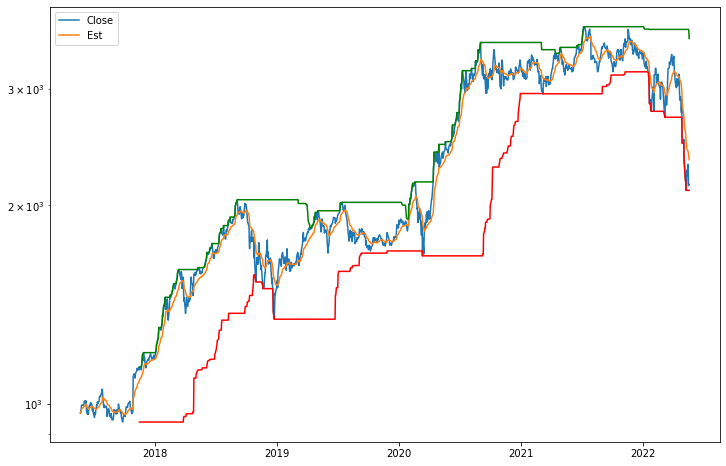

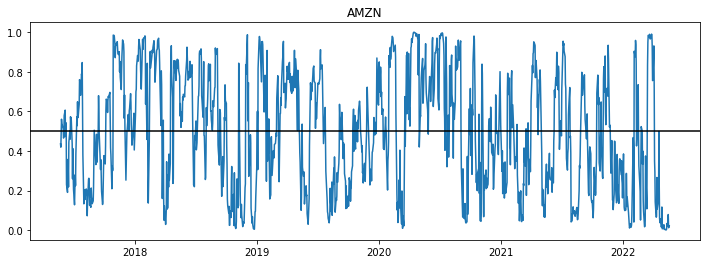

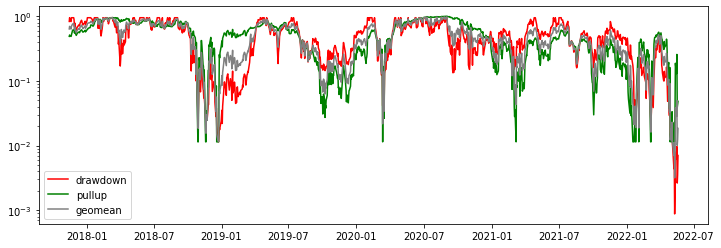

In [18]:
process_stock('AMZN', data.copy(), plot=True)

In [19]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... ADYEY... AMD... AMZN... ANET... APPH... AXON... BROS... BYND... CHWY... COIN... COUR... CRWD... DDOG... DKNG... DOCS... DOCU... DUOL... EDIT... ETSY... FLGT... FUV... FVRR... GH... GMED... GOOG... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... NYT... OKTA... OPEN... PANW... PINS... PTON... QDEL... RBLX... RDFN... RGEN... ROKU... RVLV... SE... SHOP... SNOW... SPLK... SQ... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... UPST... VEEV... WK... XPEV... ZEN... ZNGA... 

In [20]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out['RSIRev'] = 1 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('stock')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
0,AAPL,0,0.037721,0.962279,0.051587,0.051587,0.066021,0.014965,0.031432,0.040268,1.000256
1,ABMD,0,0.087480,0.912520,0.061905,0.061905,0.094190,0.055458,0.072274,0.066889,0.480759
2,ABNB,0,0.082857,0.917143,0.030220,0.030220,0.041667,0.083333,0.058926,0.042199,0.032303
3,ADYEY,1,0.252308,0.747692,0.347892,0.347892,0.044444,0.127778,0.075359,0.161916,0.943472
4,AMD,1,0.341091,0.658909,0.361111,0.361111,0.027289,0.129401,0.059424,0.146488,1.049298
...,...,...,...,...,...,...,...,...,...,...,...
66,VEEV,1,0.195024,0.804976,0.161905,0.161905,0.014965,0.177817,0.051585,0.091388,0.698101
67,WK,0,0.020064,0.979936,0.015079,0.015079,0.006162,0.087148,0.023173,0.018693,0.822364
68,XPEV,1,0.456265,0.543735,0.544622,0.544622,0.121406,0.169329,0.143379,0.279441,0.465865
69,ZEN,0,0.091493,0.908507,0.053968,0.053968,0.139085,0.192782,0.163747,0.094006,0.846770


In [21]:
out.geomean.quantile([0.05, 0.99])

0.05    0.015716
0.99    0.596410
Name: geomean, dtype: float64

In [22]:
out.to_csv('individ_quantiles.csv', index=False)

In [23]:
!open individ_quantiles.csv